In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import Bounds, minimize

# Styling
plt.style.use('ggplot')

#### The cell below calculates the global minimum variance portfolio

* The $(n \times 1)$ vector $\mathbf{R}$ contains the $n$ risky (annualized) returns.:
$$
\mathbf{R}=\left(\begin{array}{c}
r_{1} \\
r_{2} \\
\cdot \\
\cdot \\
r_{n}
\end{array}\right)
$$

* The $(n \times n)$ covariance-matrix $\boldsymbol{\Sigma}$ contains the $n$ variances and $n(n-1)$ covariances:
$$
\boldsymbol{\Sigma}=\left(\begin{array}{ccccc}
\sigma_{1}^{2} & \sigma_{12} & \sigma_{13} & \ldots & \sigma_{1 n} \\
\sigma_{12} & \sigma_{2}^{2} & \sigma_{23} & \ldots & \sigma_{2 n} \\
& & \cdots & \\
& & \cdots & \\
\sigma_{n 1} & \sigma_{n 2} & \sigma_{n 3} & \ldots & \sigma_{n}^{2}
\end{array}\right)
$$
where $\sigma_{i j}=\operatorname{Cov}\left(r_{i}, r_{j}\right) .$ Note: $\boldsymbol{\Sigma}$ is symmetric, as $\sigma_{i j}=\sigma_{j i}$
* The $(n \times 1)$ vector w contains the portfolio weights for the $n$ assets: $\mathbf{w}=\left(\begin{array}{llll}w_{1} & w_{2} & \ldots & w_{n}\end{array}\right)^{\prime}$
* The $(n \times 1)$ vector i contains ones: $\mathbf{i}=\left(\begin{array}{llll}1 & 1 & \ldots & 1\end{array}\right)^{\prime}$
* The risk-free rate is denoted $r_{f}$
* We define the Capital Allocation Line as,
$$
E\left(R\right)=r_{f}+S_{p}\cdot\sigma
$$
where $S_{p}$ is the Sharpe-ratio

#### Solution

The efficient frontier is found by solving the following minimization problem
\begin{align*}
    \min_{\mathbf{w}}\;\sigma_{p}^{2}&=\mathbf{w}^{\prime}\mathbf{\Sigma}\mathbf{w},\tag{1}\\
    \text{ s.t. }&\mathbf{w}^{\prime}E(\mathbf{R})=\bar{r}_{p}\tag{2}\\
    \text{ and }&\mathbf{w}^{\prime}\mathbf{i}=1\tag{3}
\end{align*}

for different values of $\bar{r}_p$ where $\bar{r}_p$ is the is greater than the global minimum-variance portfolio's expected return.

This is what we're simulating here by applying linearly spaced $\bar{r}_p$ guesses and solving for the lowest possible portfolio variance - given the conditions stated (eq. _(1)_, _(2)_ and _(3)_).


#### Note

Although this notebook runs on data from a user-input _(covariances, returns etc.)_, I will make a version available soon, which relies on a data-driven approach using real stock-prices.

In [2]:
# Asset names - just for fun...
asset_names = ['Stocks', 'Bonds', 'Corp. Bonds']

# Asset returns
returns = np.array([
    0.0427, 0.0015, 0.0285
]).T

# Covariance matrix
cov = np.matrix([
    [0.01000, 0.00180, 0.00110],
    [0.00180, 0.01090, 0.00260],
    [0.00110, 0.00260, 0.01991]
])

# Risk free rate
risk_free = 0.005

# Linearly spaced values for calculating frontier based on returns
expected_returns = np.linspace(start=0.01, stop=0.08, num=1000)

# Maximum Asset Allocation (short/long)
bounds = Bounds(-1, 1)

In [3]:
def efficient_portfolio(Sigma, R, r_p):
    def random_weights(n):
        # makes vector of weights - always sums to 1
        random = np.random.rand(n)
        return np.matrix(random/random.sum()).T
    
    def objective_function(w):
        # equation (1)
        return np.linalg.multi_dot([w.T, Sigma, w]) 

    def return_constraint(w):
        # equation (2)
        return np.dot(w.T, R.T) - np.array([r_p])
    
    def weight_sums_constraint(w):
        # equation (3)
        return np.dot(w.T, np.ones(R.shape[0])) - np.ones(1)

    constraints = ([{'type': 'eq', 'fun': weight_sums_constraint},
                    {'type': 'eq', 'fun': return_constraint}])

    W = minimize(fun=objective_function, x0=random_weights(R.shape[0]), bounds=bounds, method='SLSQP', constraints=constraints)
    
    return {'weigths': W.x,
            'Std Dev': np.sqrt(W.fun),
            'Expected Return': r_p} 

In [4]:
# function to calculate sharpe ratio
def sharpe(r_p, r_f, sigma_p):
    return (r_p - r_f) / sigma_p


# placeholder for results
df = pd.DataFrame(columns=asset_names)


# run iterations and generate frontier (solving system for linear spaces \bar{r}_p)
for mu in expected_returns:
    results = efficient_portfolio(cov, returns, mu)
    weights_dict = dict(zip(asset_names, results['weigths']))
    
    # drop weigths element from results and add r_p and sigma to weigths dict
    results.pop('weigths')
    weights_dict.update(results)
    
    df = df.append(weights_dict, ignore_index=True)


# calculate Sharpe ratio
df['sharpe'] = sharpe(df['Expected Return'], risk_free, df['Std Dev'])
    
df.head(10)

,Stocks,Bonds,Corp. Bonds,Expected Return,Std Dev,sharpe
0,0.118071,0.747282,0.134647,0.010000,0.086389,0.057878
1,0.119592,0.745486,0.134922,0.010070,0.086271,0.058769
2,0.121112,0.743691,0.135198,0.010140,0.086152,0.059663
3,0.122632,0.741895,0.135473,0.010210,0.086035,0.060559
4,0.124152,0.740099,0.135748,0.010280,0.085917,0.061458
5,0.125672,0.738304,0.136024,0.010350,0.085800,0.062358
6,0.127193,0.736508,0.136299,0.010420,0.085684,0.063261
7,0.128713,0.734712,0.136575,0.010490,0.085567,0.064166
8,0.130233,0.732917,0.136850,0.010561,0.085452,0.065073
9,0.131753,0.731121,0.137126,0.010631,0.085336,0.065982


#### Optimal and minimum variance portfolio

Although we could have solved for the optimal portfolio as the combination of the assets which yields the highest Sharpe-ratio, we here simulate and should recieve an estimate close to if we solved the system for the combination of weights yielding the highest Sharpe-ratio.

The same argument extends to the minimum variance portfolio, which is also solved by simulation.

In [5]:
# find optimal and minimum variance portfolios from simulated data
optimal = df.loc[df['sharpe'] == df['sharpe'].max()]
min_var = df.loc[df['Std Dev'] == df['Std Dev'].min()]

In [6]:
# generate the Capital Allocation Line (CAL) to add to the plot
def cal(xs, sharpe, r_f):
    return r_f + sharpe*xs

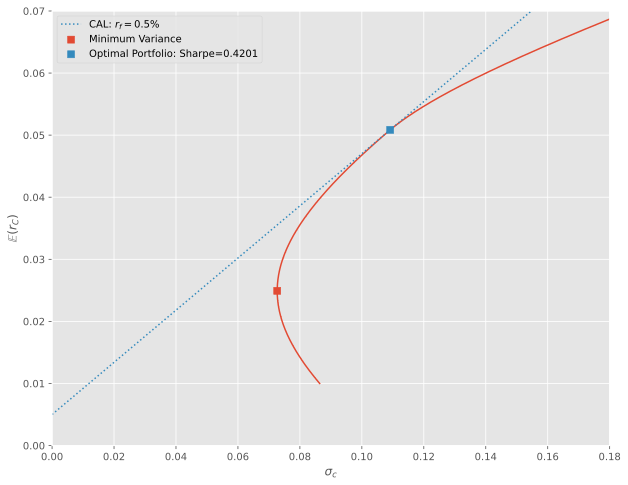

In [7]:
# Plots
plt.figure(figsize=(10,8))

plt.ylim(0.00, 0.07)
plt.xlim(0.0, 0.18)

plt.xlabel(r'$\sigma_c$')
plt.ylabel(r'$\mathbb{E}(r_C)$')

# plot efficient frontier
plt.plot(df['Std Dev'], df['Expected Return'])

# Plot minimum-var
plt.scatter(min_var['Std Dev'], 
            min_var['Expected Return'], 
            marker='s', s=50, label='Minimum Variance')

# Plot optimal
plt.scatter(optimal['Std Dev'], 
            optimal['Expected Return'], 
            marker='s', s=50, 
            label=f'Optimal Portfolio: Sharpe={round(optimal["sharpe"].iloc[0], 4)}', zorder=5)

# Plot cal
x = np.linspace(0,1, 1000)
plt.plot(x, cal(x, optimal["sharpe"].iloc[0], risk_free), linestyle=':', label=f'CAL: $r_f=${risk_free*100}%')

plt.legend()

plt.show()